In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob, inspect, sys, pickle

import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.inspection import permutation_importance

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/home/marie-anne/code/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [35]:
# Define best_model:
def best_model(X_train, y_train, steel, name, model):
    '''run standard scaler and gridsearch CV pipeline on models
    Args:
        -model: initiated model 
        -name : name of model as str
    return list of best estimator and table of results
    '''
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train= y_train[y_train.index.str.contains(steel)]

    
    best_model_stack = list()
    results_cv = dict()
    
    def grid_csv(params):
        
        GSCV = GridSearchCV(model, param_grid = params, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_root_mean_squared_error'], 
                            refit='neg_root_mean_squared_error', 
                            cv = 10, n_jobs=-1, verbose=True)
        best_clf = GSCV.fit(X_train, y_train)
        best_hyperparams = best_clf.best_params_
        best_score = best_clf.best_score_
        estimator = best_clf.best_estimator_
        print(best_score, best_hyperparams, estimator)
        table = best_clf.cv_results_
        results_cv[name] = table
        return estimator
 
        
    if name == 'Ridge':
        params = {'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
                  'alpha' : [0.01, 0.5, 1, 2]} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Elastic':
        params = {'l1_ratio' : [0, 0.25, 0.5, 1], 
                  'alpha' : [0, 0.5, 1, 2]} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Tree':
        params = {'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'friedman_mse', 'mae'],
                  'max_depth' : np.arange(5, 15, 1)}
        best_model_stack.append(grid_csv(params))
        
    if name == 'KNN':
        params = {'n_neighbors' : np.arange(5, 25, 5),
                 'weights' : ['uniform', 'distance'],
                 'algorithm' : ['ball_tree', 'kd_tree', 'brute', 'auto']} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'SVM':
        params = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                 'C' : [0.2, 0.5, 1]} 
        best_model_stack.append(grid_csv(params))


    if name == 'RF': 
        params = {'n_estimators' : np.arange(100, 200, 50),
                  'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'mae'],
                  'max_depth' : np.arange(5, 15, 1),
                 } 
        best_model_stack.append(grid_csv(params))
    
    if name == 'XGB':
        params = {'n_estimators' : np.arange(500, 2000, 250),
                  'gamma': np.arange(0.1, 1, 0.5),
                  'reg_lambda':[1e-8,  1e-4],
                  'max_depth' : np.arange(5, 15, 2),
                 } 
        best_model_stack.append(grid_csv(params))

        
    return best_model_stack, results_cv

In [119]:
def train_model(X_train, y_train, X_test, y_test, steel, name, model):
    '''
    predict real values using train models
    Args:
    - steel : id number
    - X_train, X_test : pandas df of features
    - y_train, y_test : pandas df of label, shape 1
    - name : name of the model as str
    - model: model with params
    return y_pred
    '''
    predictions = pd.DataFrame()
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train = y_train[y_train.index.str.contains(steel)]
    X_test = X_test[X_test.index.str.contains(steel)]
    y_test = y_test[y_test.index.str.contains(steel)]

    
    if name == 'XGB':
        X_train_df= pd.DataFrame(X_train, columns=feature_names)
        reg = model.fit(X_train_df, y_train)

    else:
        reg = model.fit(X_train, y_train)
        
    y_pred = reg.predict(X_test)
    print(y_test.shape, y_pred.shape)
    
    
    print("r2 score for training: ", r2_score(y_train, reg.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, y_pred))
    
    print("RMSE score for training: ", np.sqrt(mean_squared_error(y_train, reg.predict(X_train))))
    print("RMSE score for testing: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([0, 250], [0, 250])
    plt.xlim([0, 250])
    plt.ylim([0, 250])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    plt.title(steel + ', ' + name)
    plt.show()
    
    return reg

In [118]:
def real_pred(steel, X_val_real, y_val_real, model):
    '''
    predict real values using train models
    Args:
    - steel : id number
    - X_val_real : pandas df of features
    - y_val_real : pandas df of label, shape 1
    - model: trained model
    return y_pred
    '''
    X_val_real = X_val_real[X_val_real.index.str.contains(steel)]
    y_val_real = y_val_real[y_val_real.index.str.contains(steel)]
    
    reg_real = model.predict(X_val_real)
    
    print("r2 score for testing: ", r2_score(y_val_real, reg_real))
    print("RMSE score for testing: ", np.sqrt(mean_squared_error(y_val_real, reg_real)))

    sns.scatterplot(x=y_val_real, y=reg_real)
    plt.plot([0, 250], [0, 250])
    plt.xlim([0, 250])
    plt.ylim([0, 250])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    plt.title(steel + ', ' + name)
    plt.show()
    
    return reg_real

In [102]:
def load_data_real(path, scaler):
    '''
    load_data for consistency columns in analyses.
    Args:
    - path : path to csv file
    - scaler :sklearn scaler
    return X, y
    '''

    df = pd.read_csv(path, index_col=0)
    df.index = df.index.str.rstrip('-12345')
    df = df.groupby('ID').mean()
    df['log_MS_Avg'] = np.log(df['MS_Avg'])
    df['log_beta_avg'] = np.log(df['Beta_avg']) 
    df = df[mc.regression_cols].dropna(how='any')
    y_val_real = df['KJIC']
    X_val_real = df.drop(columns=['KJIC'])
    X_val_real = pd.DataFrame(scaler.transform(X_val_real), columns=X_val_real.columns, index=X_val_real.index)
    return  X_val_real, y_val_real

In [184]:
# Define basic features importances:
def get_feature_importance(name, model, feature_names):
    '''return classical feature importances
    Args:
        -name:str
        -model: trained model
    return importance as a df    
    '''
    if name == 'Ridge' or name == 'Elastic':
        importance = model.coef_
        importance_df = pd.DataFrame(importance.T, columns=[name], index=feature_names)
        importance_df.sort_values(name, ascending=True, inplace=True)
       
    if name == 'KNN' or name == 'SVM':
        pass
        
    if name == 'RF' or name == 'Tree': 
        importance = model.feature_importances_
        rel_importance = 100.0 * (importance / importance.sum())
        importance_df = pd.DataFrame(rel_importance.T, columns=[name], index=feature_names)
        importance_df.sort_values(name, ascending=True, inplace=True)
 
    if name == 'XGB':
        importance = model.feature_importances_
        rel_importance = 100.0 * (importance / importance.sum())
        importance_df = pd.DataFrame(rel_importance.T, columns=['XGB'], index=feature_names)
        importance_df.sort_values('XGB', ascending=True, inplace=True)
         
    return importance_df

### Import df and train test split

In [100]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori, scaler = mc.load_data(os.path.join(os.path.dirname(os.getcwd()),'../Data/Merged_data/CopulaGAN_simulated_data_up.csv'),
                                               MinMaxScaler())

In [101]:
# get feature names
feature_names=list(X_train_ori)

### Dummy regressor on all steel

In [29]:
# Evaluate naive

naive = DummyRegressor(strategy='median')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(naive, X_train_ori, y_train_ori, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('Baseline: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Baseline: -31.521 (3.286)


### GridSearch CV

In [34]:
# Create model_dict

model_GSCV = dict()

model_GSCV['Ridge'] = Ridge()
model_GSCV['Elastic'] = ElasticNet()
model_GSCV['Tree'] = DecisionTreeRegressor()
model_GSCV['KNN'] = KNeighborsRegressor()
model_GSCV['SVM'] = SVR()
model_GSCV['RF'] = RandomForestRegressor()
model_GSCV['XGB'] = xgb.XGBRegressor(objective= 'reg:squarederror',
                        eval_metric = 'rmse',
                        learning_rate = 0.01, 
                        nthread=4,
                        seed=42)


In [38]:
all_results=dict()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    print(steel)
    results_best_model = list()
    scoring = dict()
    for name, model in model_GSCV.items():

        scores = best_model(X_train_ori, y_train_ori, steel, name, model)
        results_best_model.append(scores[0][0])
        scoring[name] = pd.DataFrame(scores[1][name])

    #save params
    with pd.ExcelWriter(os.path.join(os.getcwd(), 'Results_CV/' + steel + '_result_CV.xlsx')) as writer:
        for df_name, df in scoring.items():
            df.to_excel(writer, sheet_name=df_name) 
    all_results[steel] = results_best_model
    with open('Results_CV/all_results_CV.p', 'wb') as fp:
        pickle.dump(all_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


347
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


-14.05914056977286 {'alpha': 0.01, 'solver': 'saga'} Ridge(alpha=0.01, solver='saga')
A286
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


-17.643119510386917 {'alpha': 0.01, 'solver': 'lsqr'} Ridge(alpha=0.01, solver='lsqr')
316
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


-12.315286681615566 {'alpha': 0.01, 'solver': 'saga'} Ridge(alpha=0.01, solver='saga')
304
Fitting 10 folds for each of 28 candidates, totalling 280 fits
-14.500668015955947 {'alpha': 0.01, 'solver': 'saga'} Ridge(alpha=0.01, solver='saga')


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    0.5s finished


If you need to add another regressor:

create a new dictionary in the for loop as for example all_results_ridge dict and comment out other regressors in the model_GSCV dict 
then the results and rerun pickle save:


`for k, v in dict_results.items():
    if k in all_results_ridge.keys():
        all_results_ridge[k] += v
    else:
        all_results_ridge[k] = v`


## Regression

In [58]:
with open('Results_CV/all_results_CV.p', 'rb') as fp:
    dict_results = pickle.load(fp)
    print(dict_results)

{'347': [Ridge(alpha=0.01, solver='saga'), ElasticNet(alpha=0, l1_ratio=0), DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto'), KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, weights='distance'), SVR(C=1, kernel='poly'), RandomForestRegressor(max_depth=13), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=1e-08, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)], 'A286': [Ridge(alpha=0.01, solver='lsqr'), Elast

(58,) (58,)
r2 score for training:  0.9274114632246979
r2 score for testing:  0.9122904560948304
RMSE score for training:  13.512422815605667
RMSE score for testing:  12.350792404831545


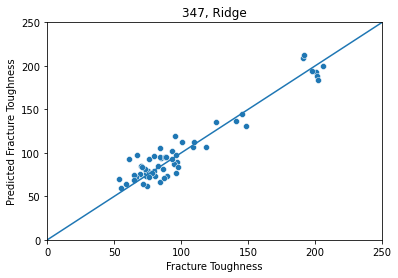

(58,) (58,)
r2 score for training:  0.9274608948524914
r2 score for testing:  0.9115575123905931
RMSE score for training:  13.507821160593005
RMSE score for testing:  12.402289665559302


<ipython-input-119-48ed126cd193>:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18337.353866909798, tolerance: 50.55853344101947
  model = cd_fast.enet_coordinate_descent(


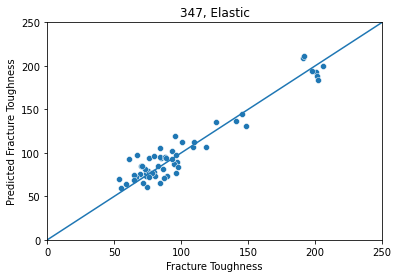

(58,) (58,)
r2 score for training:  0.9745657075077773
r2 score for testing:  0.8864420986888252
RMSE score for training:  7.998508964025591
RMSE score for testing:  14.053356860081282


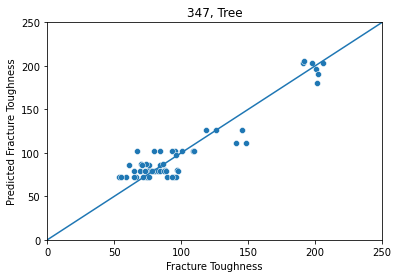

(58,) (58,)
r2 score for training:  1.0
r2 score for testing:  0.9312943148525363
RMSE score for training:  0.0
RMSE score for testing:  10.931197301969997


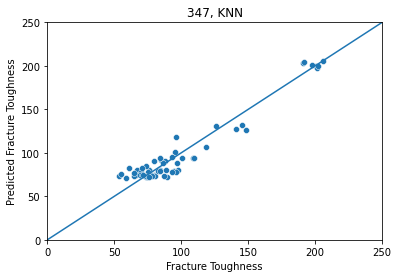

(58,) (58,)
r2 score for training:  0.930397586168002
r2 score for testing:  0.8910514428918543
RMSE score for training:  13.231569303520565
RMSE score for testing:  13.765187682110845


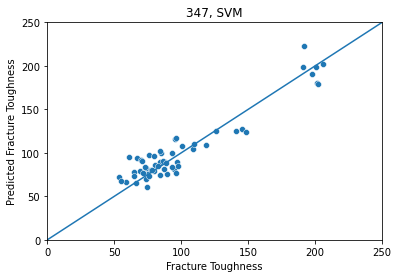

(58,) (58,)
r2 score for training:  0.9913705708474737
r2 score for testing:  0.9147755336182761
RMSE score for training:  4.65897348667042
RMSE score for testing:  12.174567475966107


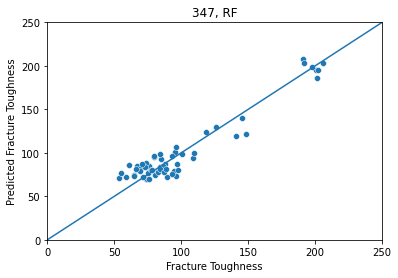

(58,) (58,)
r2 score for training:  0.996812990643344
r2 score for testing:  0.9071458803226777
RMSE score for training:  2.8313325022109535
RMSE score for testing:  12.707847199619131


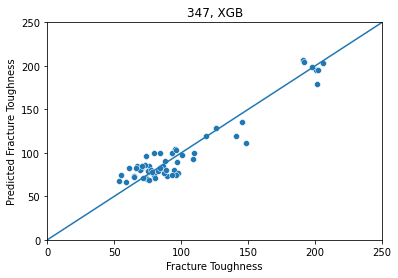

(41,) (41,)
r2 score for training:  0.8982620917699395
r2 score for testing:  0.9081949043998012
RMSE score for training:  17.208810963875248
RMSE score for testing:  18.2833570306832


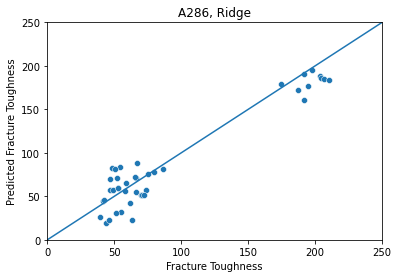

(41,) (41,)
r2 score for training:  0.8984179806292865
r2 score for testing:  0.90818530456517
RMSE score for training:  17.195621729006675
RMSE score for testing:  18.284312928690493


<ipython-input-119-48ed126cd193>:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26168.512488267173, tolerance: 51.521937938185204
  model = cd_fast.enet_coordinate_descent(


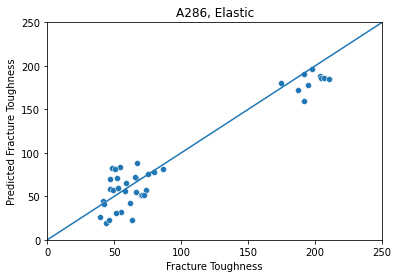

(41,) (41,)
r2 score for training:  0.9795742157576076
r2 score for testing:  0.9742951327318345
RMSE score for training:  7.710789227616645
RMSE score for testing:  9.674537878037324


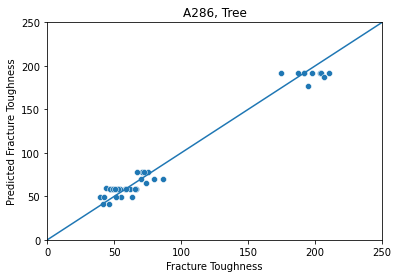

(41,) (41,)
r2 score for training:  1.0
r2 score for testing:  0.976136748827435
RMSE score for training:  0.0
RMSE score for testing:  9.321533242777127


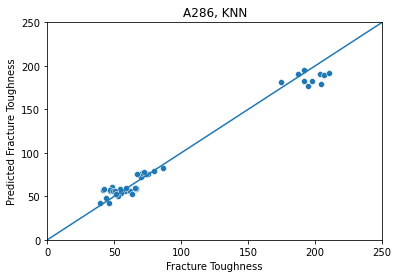

(41,) (41,)
r2 score for training:  0.8641440730454769
r2 score for testing:  0.867176821449905
RMSE score for training:  19.886060525533278
RMSE score for testing:  21.991734360101727


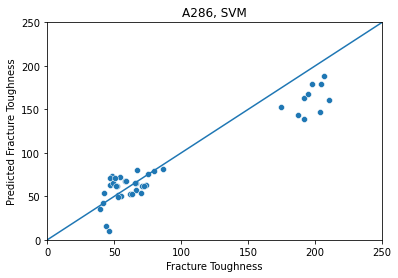

(41,) (41,)
r2 score for training:  0.9906779812452259
r2 score for testing:  0.9748709442372399
RMSE score for training:  5.20912103010975
RMSE score for testing:  9.565565095788166


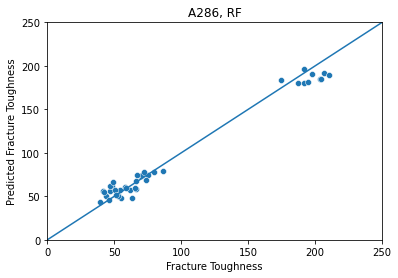

(41,) (41,)
r2 score for training:  0.9982225385475062
r2 score for testing:  0.9539347714381791
RMSE score for training:  2.274623687047609
RMSE score for testing:  12.95117469991208


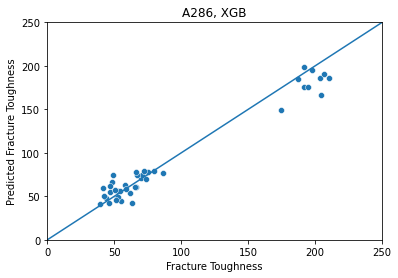

(53,) (53,)
r2 score for training:  0.6962992791748616
r2 score for testing:  0.6734978612924527
RMSE score for training:  12.20112971011445
RMSE score for testing:  14.189267764838563


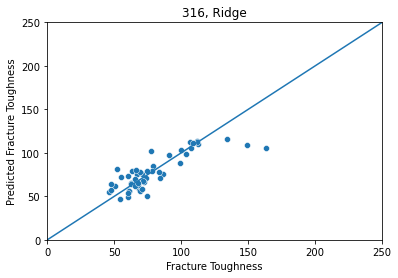

(53,) (53,)
r2 score for training:  0.6963214887707116
r2 score for testing:  0.6737700444211869
RMSE score for training:  12.200683568410467
RMSE score for testing:  14.183352207079382


<ipython-input-119-48ed126cd193>:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15778.808030866963, tolerance: 10.391784368933124
  model = cd_fast.enet_coordinate_descent(


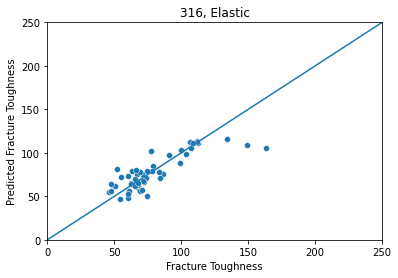

(53,) (53,)
r2 score for training:  0.9999873173939611
r2 score for testing:  0.5741430098528317
RMSE score for training:  0.07884631193221023
RMSE score for testing:  16.204993429111244


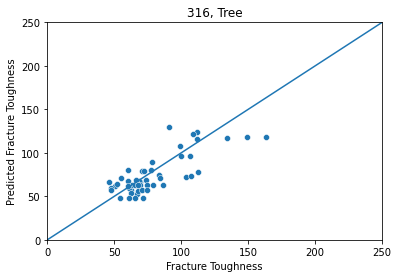

(53,) (53,)
r2 score for training:  0.9999999999998636
r2 score for testing:  0.7252480861314002
RMSE score for training:  8.178994416603298e-06
RMSE score for testing:  13.016293484619467


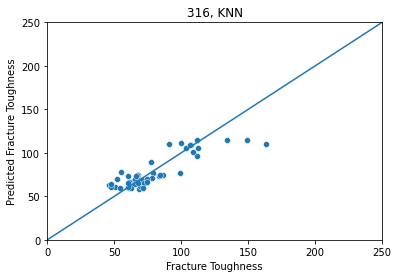

(53,) (53,)
r2 score for training:  0.6215415293539392
r2 score for testing:  0.6005640887935363
RMSE score for training:  13.62028665151152
RMSE score for testing:  15.694248427021742


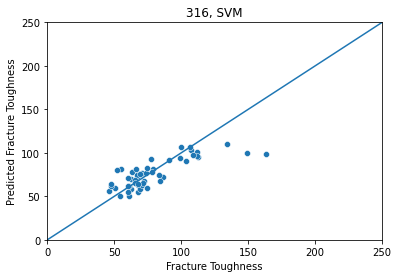

(53,) (53,)
r2 score for training:  0.9511810852340452
r2 score for testing:  0.7672047913407752
RMSE score for training:  4.891828165483659
RMSE score for testing:  11.98130124900268


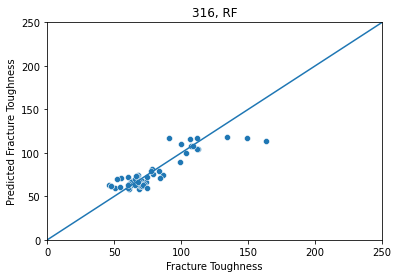

(53,) (53,)
r2 score for training:  0.9896557777954024
r2 score for testing:  0.7354998948799005
RMSE score for training:  2.2517804969278754
RMSE score for testing:  12.771146700601284


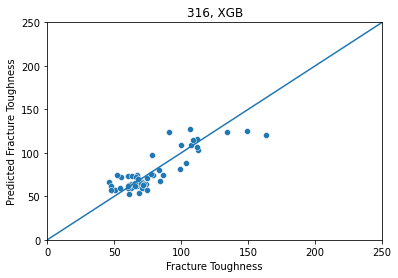

(48,) (48,)
r2 score for training:  0.7934767053140188
r2 score for testing:  0.7401211262285139
RMSE score for training:  14.134867159146962
RMSE score for testing:  12.776708182609818


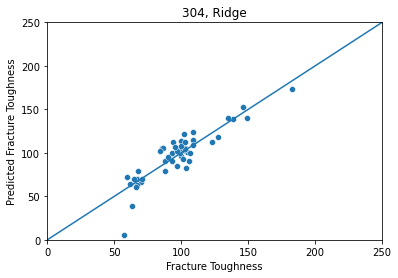

(48,) (48,)
r2 score for training:  0.7935679959184216
r2 score for testing:  0.7299337459904318
RMSE score for training:  14.131742758100415
RMSE score for testing:  13.02472756305527


<ipython-input-119-48ed126cd193>:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20969.146105017968, tolerance: 20.315789887629375
  model = cd_fast.enet_coordinate_descent(


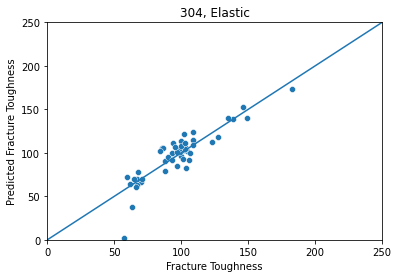

(48,) (48,)
r2 score for training:  0.8620325842318486
r2 score for testing:  0.536029846210149
RMSE score for training:  11.553018632714812
RMSE score for testing:  17.071768378116467


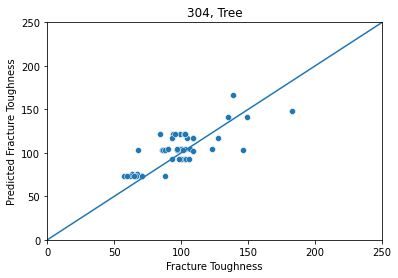

(48,) (48,)
r2 score for training:  1.0
r2 score for testing:  0.8247603482282762
RMSE score for training:  0.0
RMSE score for testing:  10.491792153335714


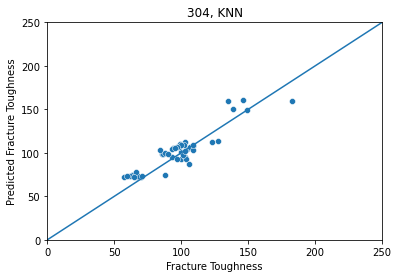

(48,) (48,)
r2 score for training:  0.785372739976394
r2 score for testing:  0.7727184593611689
RMSE score for training:  14.409524493653453
RMSE score for testing:  11.948560035033752


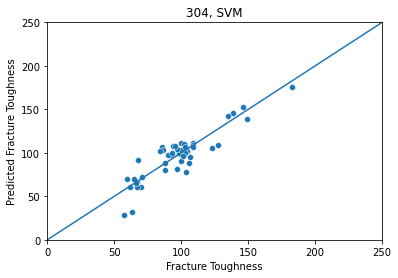

(48,) (48,)
r2 score for training:  0.8987939339248467
r2 score for testing:  0.776983595517341
RMSE score for training:  9.894878843158136
RMSE score for testing:  11.835916498363874


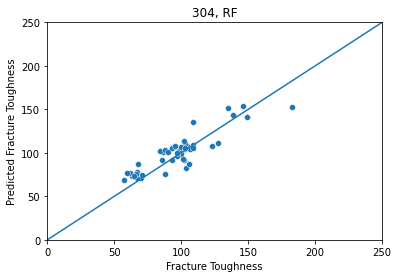

(48,) (48,)
r2 score for training:  0.9949937056673877
r2 score for testing:  0.6133909009694645
RMSE score for training:  2.2007230822205277
RMSE score for testing:  15.58366211547807


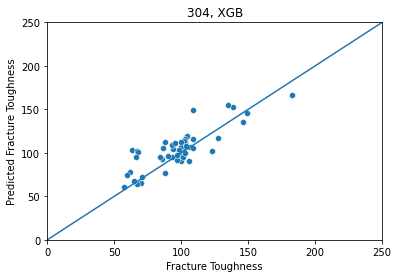

In [122]:
model_names = ['Ridge', 'Elastic', 'Tree', 'KNN', 'SVM', 'RF', 'XGB']
all_regressors=dict()

for steel in set(X_train_ori.index.str.split('-').str[0]):
    
    # Create model_dict
    list_results = dict_results[steel]
    models = dict(zip(model_names, list_results))
    
    # Fit models
    regressors = list()
    for name, model in models.items():
        reg = train_model(X_train_ori, y_train_ori, X_test_ori, y_test_ori, steel, name, model)
        regressors.append(reg)
        
    all_regressors[steel] = regressors
    
    #save params

    with open('Results_CV/all_regressors.p', 'wb') as fp:
        pickle.dump(all_regressors, fp, protocol=pickle.HIGHEST_PROTOCOL)

    

# Test on real data

In [93]:
with open('Results_CV/all_regressors.p', 'rb') as fp:
    dict_regressors = pickle.load(fp)
    print(dict_regressors)

{'347': [Ridge(alpha=0.01, solver='saga'), ElasticNet(alpha=0, l1_ratio=0), DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto'), KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, weights='distance'), SVR(C=1, kernel='poly'), RandomForestRegressor(max_depth=13)], 'A286': [Ridge(alpha=0.01, solver='lsqr'), ElasticNet(alpha=0, l1_ratio=0), DecisionTreeRegressor(max_depth=5, max_features='log2'), KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights='distance'), SVR(C=1, kernel='poly'), RandomForestRegressor(criterion='mae', max_depth=7, max_features='log2',
                      n_estimators=150)], '316': [Ridge(alpha=0.01, solver='saga'), ElasticNet(alpha=0, l1_ratio=0), DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                      max_features='sqrt'), KNeighborsRegressor(algorithm='brute', n_neighbors=20, weights='distance'), SVR(C=1, kernel='poly'), RandomForestRegressor(criterion='mae', ma

In [103]:
X_val_real, y_val_real = load_data_real(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
               scaler) # using the scaler from the load_data

r2 score for testing:  0.9608801835410283
RMSE score for testing:  9.16121762395182


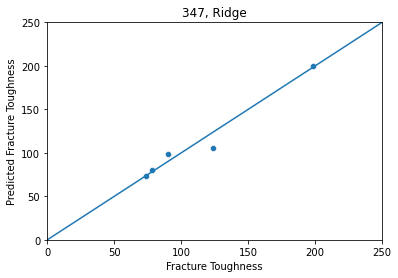

r2 score for testing:  0.9616615254660019
RMSE score for testing:  9.069267462809227


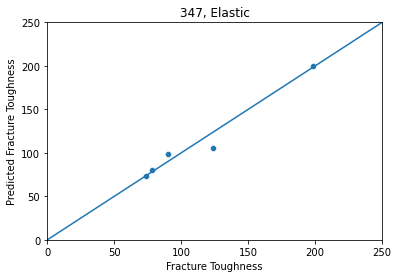

r2 score for testing:  0.9804444873028997
RMSE score for testing:  6.47723119650437


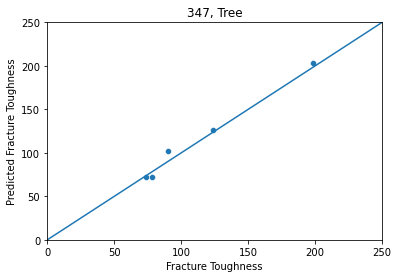

r2 score for testing:  0.9943655461710555
RMSE score for testing:  3.476807996716163


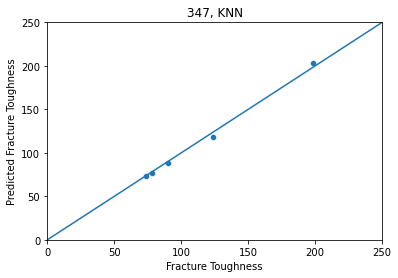

r2 score for testing:  0.980832750486545
RMSE score for testing:  6.4126080198792215


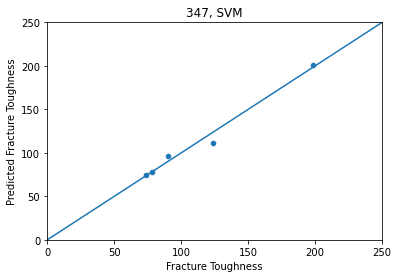

r2 score for testing:  0.9949993493873062
RMSE score for testing:  3.275427958099495


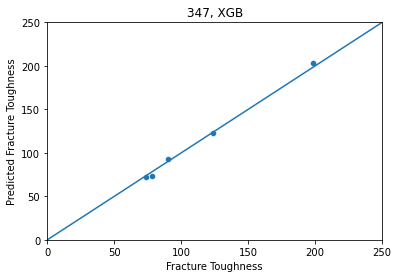

r2 score for testing:  0.996832934358982
RMSE score for testing:  3.216004301285807


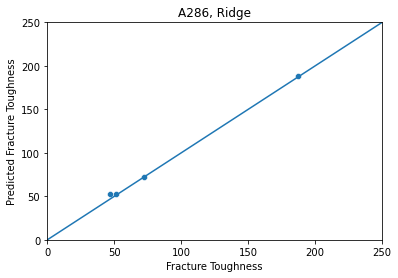

r2 score for testing:  0.9973581499623899
RMSE score for testing:  2.937258500826998


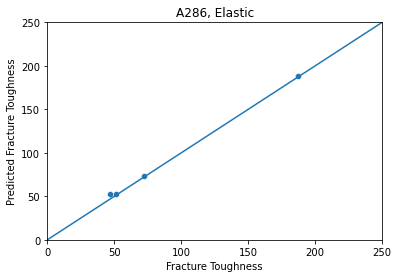

r2 score for testing:  0.9935990919641812
RMSE score for testing:  4.5720280097379815


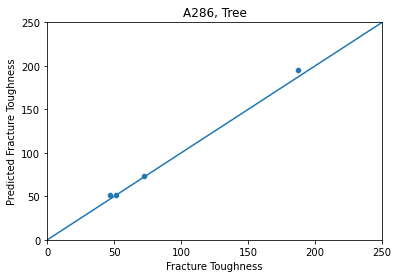

r2 score for testing:  0.9879949415893325
RMSE score for testing:  6.26138238760557


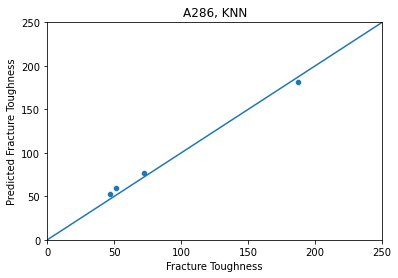

r2 score for testing:  0.995500738682448
RMSE score for testing:  3.8331754452319466


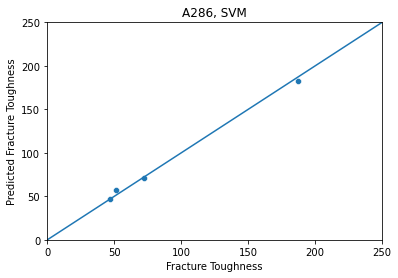

r2 score for testing:  0.989706173864724
RMSE score for testing:  5.79797719604144


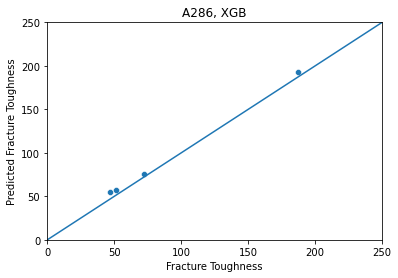

r2 score for testing:  0.8488068353655128
RMSE score for testing:  7.090207005514412


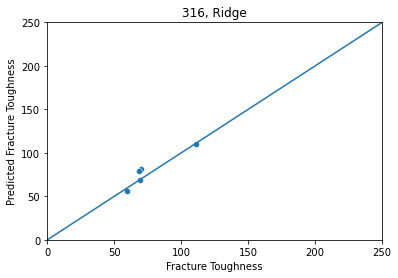

r2 score for testing:  0.8491927389198842
RMSE score for testing:  7.08115274620678


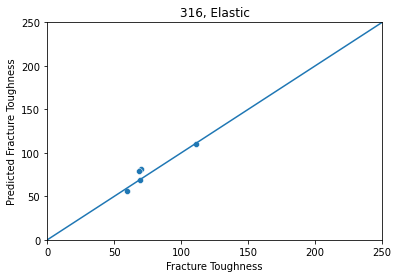

r2 score for testing:  0.8017628057193151
RMSE score for testing:  8.118679693455503


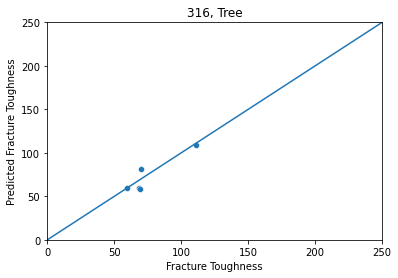

r2 score for testing:  0.9793138152260243
RMSE score for testing:  2.6226059134695365


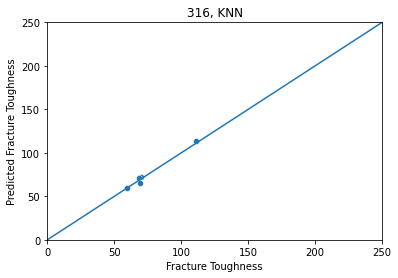

r2 score for testing:  0.7105791761746849
RMSE score for testing:  9.809745130849603


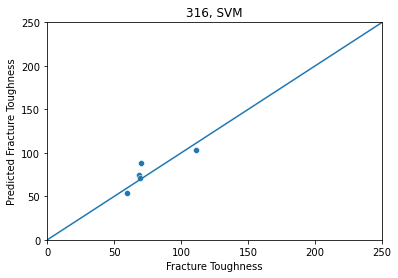

r2 score for testing:  0.8338210627860171
RMSE score for testing:  7.433285692668664


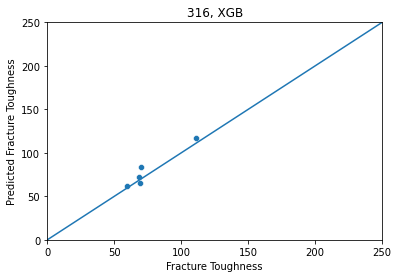

r2 score for testing:  0.9670699720779012
RMSE score for testing:  5.392656130702437


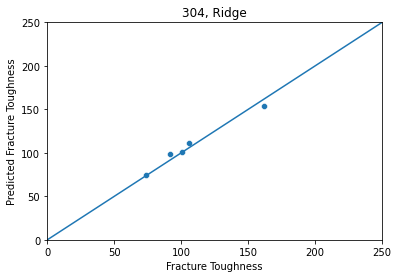

r2 score for testing:  0.9673575473133852
RMSE score for testing:  5.3690576848517395


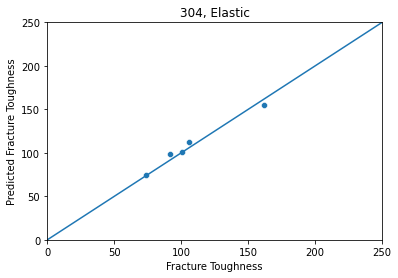

r2 score for testing:  0.9616495939794164
RMSE score for testing:  5.819580252100992


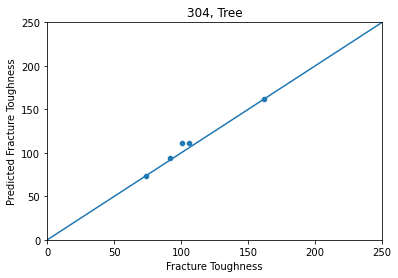

r2 score for testing:  0.9782861551588821
RMSE score for testing:  4.379000990972239


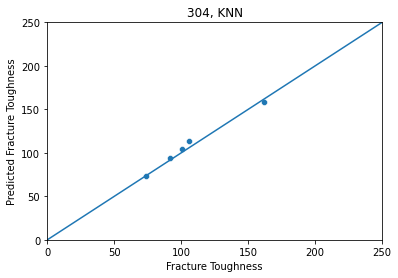

r2 score for testing:  0.967042269444717
RMSE score for testing:  5.394923960070992


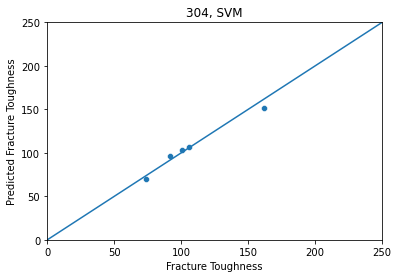

r2 score for testing:  0.9850488713051507
RMSE score for testing:  3.6336548137364413


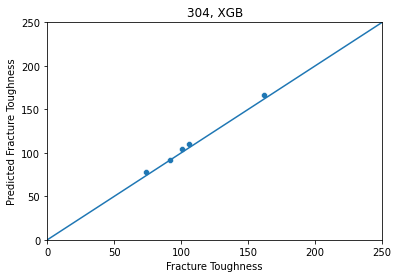

In [120]:
real_regressors = dict()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    
    reg_real_list = list()
    
    # Create model_dict
    list_reg = dict_regressors[steel]
    models = dict(zip(model_names, list_reg))
    for name, model in models.items():
        reg_real = real_pred(steel, X_val_real, y_val_real, model)
        reg_real_list.append(reg_real)
        
    real_regressors[steel] = reg_real_list
    
    #save params

    with open('Results_CV/all_regressors_real.p', 'wb') as fp:
        pickle.dump(all_regressors, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Feature importance

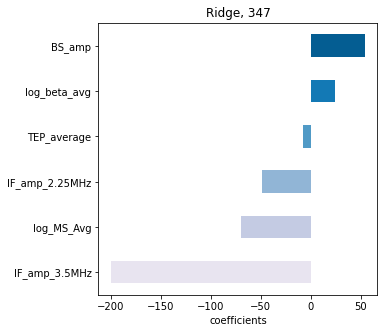

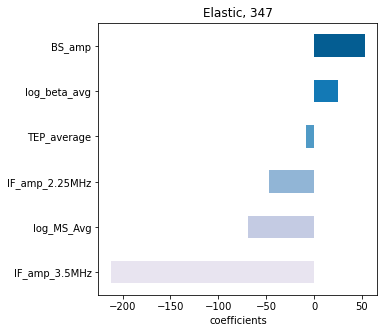

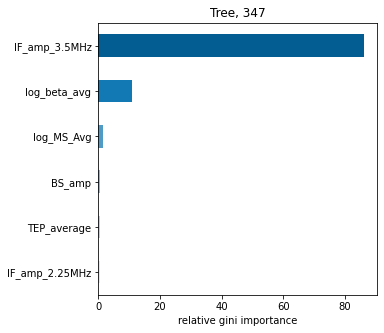

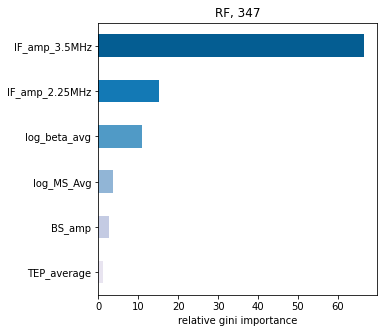

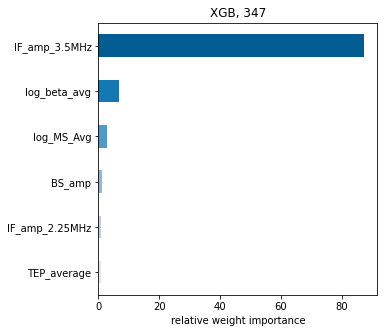

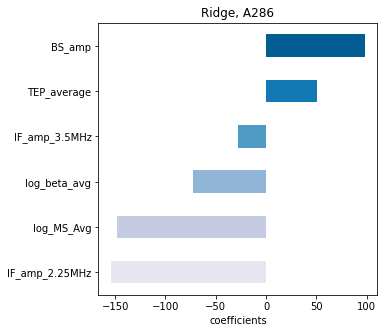

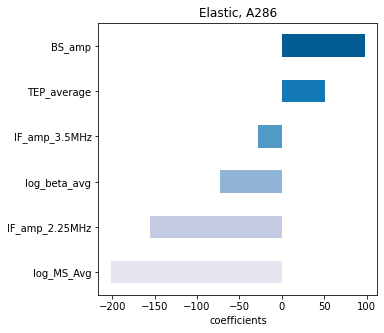

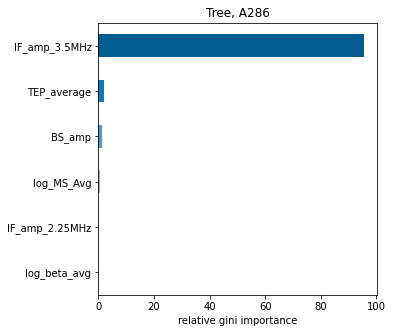

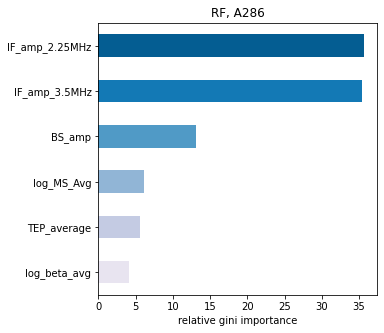

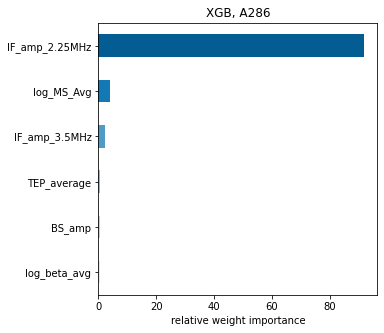

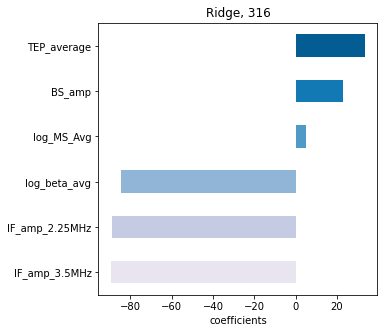

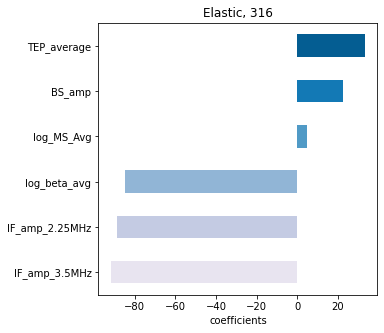

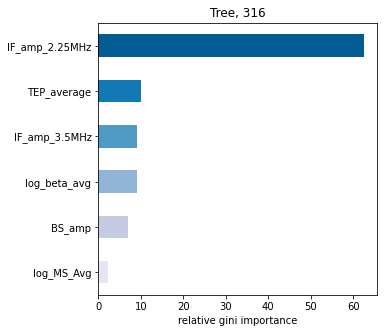

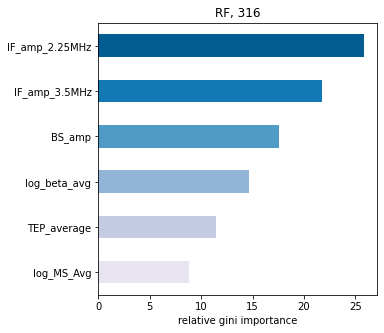

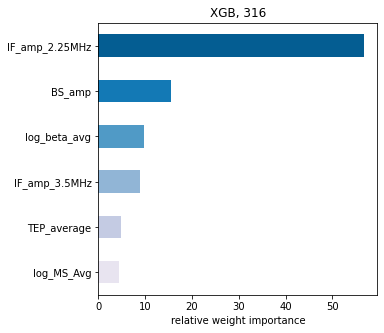

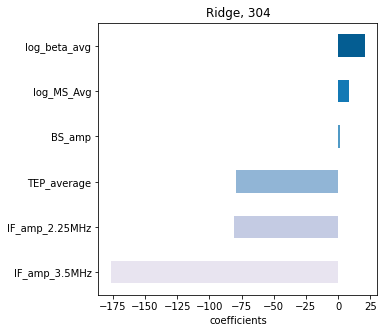

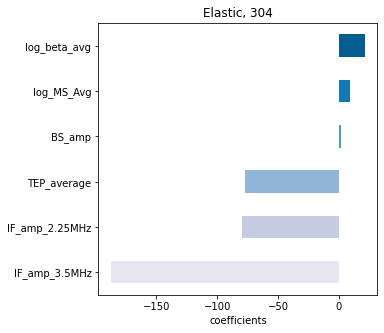

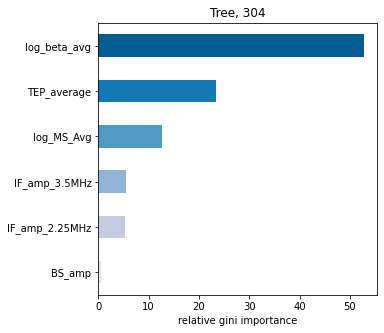

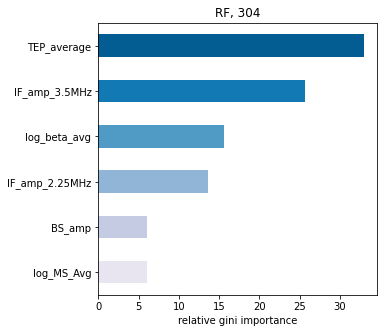

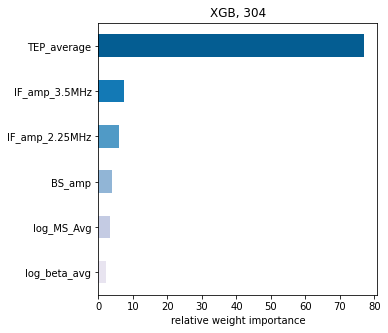

In [186]:
model_names = ['Ridge', 'Elastic', 'Tree', 'KNN', 'SVM', 'RF', 'XGB']

for steel in set(X_train_ori.index.str.split('-').str[0]):
        
    # Create model_dict
    list_results = dict_results[steel]
    models = dict(zip(model_names, list_results))

    for name, model in models.items():
        if name == 'KNN' or name == 'SVM':
            continue
        classic = get_feature_importance(name, model, feature_names)
        classic.plot.barh(figsize=(5,5), color=[sns.color_palette(palette='PuBu', n_colors=len(feature_names))], 
                          legend=False, title=name + ', ' + steel)
       
        if name=='Ridge' or  name=='Elastic' or name=='SVM':
            plt.xlabel('coefficients')

        if name=='RF' or name == 'Tree':
            plt.xlabel('relative gini importance') 
            
        if name=='XGB':
            plt.xlabel('relative weight importance')

